## reading images from path and extracting SIFT features

In [123]:
def read(path):
    img= cv2.imread(path)
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     cv2.imshow("Original image",gray)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    sift= cv2.xfeatures2d.SIFT_create()

#     keypoints= sift.detect(gray,None)
    keypoints, descriptors=sift.detectAndCompute(gray,None)
    draw_keypoints(img, keypoints, gray, path)
    return keypoints, descriptors, gray,img

## drawing keypoints on the respective images 

In [124]:
def draw_keypoints(color_image, keypoints, gray_image, og):
    color_image=cv2.drawKeypoints(color_image, keypoints,gray_image,color=(0,0,0))
    cv2.imwrite(og+"task1_sift1.jpg", color_image)
    cv2.imshow("key points", color_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## matching keypoints using K nearest neighbours 

In [125]:
def match(keypoints1, descriptor1, keypoints2, descriptor2):
    comp_neighbour=2
    matcher= cv2.BFMatcher()
    matches= matcher.knnMatch(descriptor1,descriptor2, comp_neighbour)
    
    good_match=[]
    
    pts1=[]
    pts2=[]
    for m,n in matches:
        if(m.distance<0.75*(n.distance)):
            good_match.append(m)
            pts1.append(keypoints1[m.queryIdx].pt)
            pts2.append(keypoints2[m.trainIdx].pt)
    
    
    
    return good_match, pts1,pts2
        

## draw matches using matches obtained using K nearest neighbour algorithm

In [126]:
def draw_matches( image1, image2, keypoint1,keypoint2, matches):
    
    result_knn= cv2.drawMatches(image1,keypoint1,image2,keypoint2,matches,None,flags=2,matchColor=(0,0,0))
    cv2.imwrite("task1_matches_knn.jpg", result_knn)
    cv2.imshow("result ", result_knn )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return result_knn

## calculating fundamental matrix

In [127]:
def fundamental(goodmatches, keypoints1, keypoints2):
    image1=np.array([keypoints1[m.queryIdx].pt for m in goodmatches]).reshape(-1,1,2)
    image2=np.array([keypoints2[m.trainIdx].pt for m in goodmatches]).reshape(-1,1,2)
    
    fundamental_matrix, mask = cv2.findFundamentalMat(image1,image2,cv2.RANSAC)
    
    return fundamental_matrix, mask

In [129]:
def drawlines(img1,img2,lines,points_1,points_2,flags):

    r, c = img1.shape
    
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2,clr_flag in zip(lines,points_1,points_2, flags):
#         color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])

        if(clr_flag==1):
            color=(155,255,178)
        else:
            color=(0,255,255) 

        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,(int(pt1[0]),int(pt1[1])),5,color,-1)
        img2 = cv2.circle(img2,(int(pt2[0]),int(pt2[0])),5,color,-1)
    return img1,img2

## DISPARITY LOGIC

In [130]:
def disparity(left_image, right_image):
    img1=cv2.imread(left_image)
    img2=cv2.imread(right_image)
    gray1=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2=cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    stereo= cv2.StereoBM_create( numDisparities=16, blockSize=15)
   
    disparity = stereo.compute(gray1,gray2)
    plt.imshow(disparity)

## MAIN FUNCTION

In [131]:
def main():
    source1="tsucuba_left.png"
    source2="tsucuba_right.png"
    keypoints1, descriptor1, img1, img1color =read(source1)  
    keypoints2, descriptor2,img2, img2color =read(source2)
    
    good_matches, pts1, pts2=match(keypoints1,descriptor1,keypoints2,descriptor2)
    
    
    draw_matches(img1,img2,keypoints1,keypoints2,good_matches)
    
    fundamental_matrix, mask=fundamental(good_matches, keypoints1,keypoints2)
    print("-------------FUNDAMENTAL MATRIX-------------")
    print(fundamental_matrix)
    
    
    print("---------------------------------------------")
    pts1=np.array(pts1)
    pts2=np.array(pts2)
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    
   
    #drawing inliers when a feature matches.
    lines1 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 2,fundamental_matrix)
    lines1 = lines1.reshape(-1,3)
    
    rand_points1=[]
    rand_points2=[]
    rand_lines=[]
    flags=[]
    
    for i in range(0,10):
        j=np.random.randint(len(pts1))
        print("random indexes generated in 1",j)
        rand_points1.append(pts1[j])
        rand_points2.append(pts2[j])
        rand_lines.append(lines1[j])
        flags.append(1)
        
    img3, img4=drawlines(img1,img2, rand_lines,rand_points1,rand_points2,flags)
    

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,fundamental_matrix)
    lines2 = lines2.reshape(-1,3)
    
    rand2_points1=[]
    rand2_points2=[]
    rand2_lines=[]
    flags2=[]
    
    for i in range(0,10):
        j=np.random.randint(len(pts1))
        print("random indexes generated in 2",j)
        rand2_points1.append(pts1[j])
        rand2_points2.append(pts2[j])
        rand2_lines.append(lines2[j])
        
        if rand_points1[i][0] == rand2_points1[i][0] and rand2_points2[i][1] == rand_points2[i][1]:
            flag=1
        else:
            flag=0
        flags2.append(flag)
    
    img5,img6 = drawlines(img2,img1,rand2_lines,rand2_points2,rand2_points1, flags2)
    
    
    cv2.imshow("image3", img3)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite("task2_epi_right.jpg",img3)
        
    cv2.imshow("image5", img5)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite("task2_epi_left.jpg",img5)
 
    disparity(source1,source2)
    

-------------FUNDAMENTAL MATRIX-------------
[[ 4.33940149e-06 -1.80706866e-04  3.87918242e-02]
 [ 2.13751350e-04 -1.82440049e-05  1.71262442e-01]
 [-4.24982679e-02 -1.75358943e-01  1.00000000e+00]]
---------------------------------------------
random indexes generated in 1 234
random indexes generated in 1 106
random indexes generated in 1 166
random indexes generated in 1 44
random indexes generated in 1 147
random indexes generated in 1 178
random indexes generated in 1 59
random indexes generated in 1 113
random indexes generated in 1 211
random indexes generated in 1 219
random indexes generated in 2 30
random indexes generated in 2 5
random indexes generated in 2 230
random indexes generated in 2 240
random indexes generated in 2 204
random indexes generated in 2 171
random indexes generated in 2 257
random indexes generated in 2 253
random indexes generated in 2 70
random indexes generated in 2 178


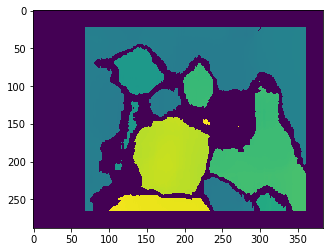

In [132]:
if __name__=="__main__":
    import cv2 
    from matplotlib import pyplot as plt
    import numpy as np
    UBIT = 'mkulshre'
    np.random.seed(sum([ord(c) for c in UBIT]))
    main()